# Bank Marketing: Term Deposit Classifier

This notebook presents an applied machine learning project to predict whether a client will subscribe to a term deposit using the UCI Bank Marketing dataset. It is framed as a binary classification task and demonstrates a clear, reproducible workflow that a data science team could hand off or extend.

- **Dataset:** UCI Bank Marketing (`bank-full.csv`) with demographic and campaign features  
- **Goal:** Build and evaluate models that estimate subscription probability for targeted outreach  
- **Methods:** Preprocessing pipelines (`ColumnTransformer` + `StandardScaler`), Logistic Regression (L2, L1, Elastic Net), stratified cross-validation  
- **Metrics:** Accuracy, ROC AUC, Precision, Recall, Confusion Matrix — with emphasis on class imbalance and thresholding  

**Why it matters:** In banking and fintech, optimising contact strategy reduces cost and customer fatigue. Calibrated probabilities and threshold selection support decisions such as who to call, when to call, and how to allocate budget across segments. This aligns with my interests in applied ML and decision support systems.

---

### Load and Explore Data

Load and explore the dataset to check its shape, feature names, and the class distribution of target variable `y`.

In [54]:
import pandas as pd
df = pd.read_csv('data/bank-full.csv', sep=';')

# Shape of the dataset
print('Shape:', df.shape)

# First few rows
df.head()

# Feature names (columns)
print('Features:', df.columns.tolist())

# Class balance for target 'y'
print('y value counts:')
print(df['y'].value_counts())
print('y proportions (%):')
print((df['y'].value_counts(normalize=True) * 100).round(2))


Shape: (45211, 17)
Features: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
y value counts:
y
no     39922
yes     5289
Name: count, dtype: int64
y proportions (%):
y
no     88.3
yes    11.7
Name: proportion, dtype: float64


## Baseline Logistic Regression

Build a baseline logistic regression model on the `bank-full.csv` dataset to predict whether a client subscribes to a term deposit.
This involves:
- Encoding categorical variables and scaling numeric features
- Training a logistic regression with default parameters
- Evaluating performance using accuracy, confusion matrix, ROC AUC, and precision/recall

### Encode Target y

Convert the target `y` into binary format (yes → 1, no → 0) and confirm counts/proportions.

In [55]:
# Convert target 'y' to binary (yes→1, no→0) and confirm distribution
df['y'] = df['y'].map({'yes': 1, 'no': 0}).astype('int64')

print('y counts (0/1):')
print(df['y'].value_counts().sort_index())
print('y proportions (%):')
print((df['y'].value_counts(normalize=True) * 100).round(2).sort_index())


y counts (0/1):
y
0    39922
1     5289
Name: count, dtype: int64
y proportions (%):
y
0    88.3
1    11.7
Name: proportion, dtype: float64


### Encode Features (One‑Hot)

Encode the specified categorical features using one‑hot encoding (drop_first=True) and preview the transformed DataFrame.

In [56]:
# One-hot encode selected categorical features (drop_first to avoid redundancy)
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
# Leave numeric columns as-is
numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype='int64')

# Preview the updated DataFrame
df.head()


,age,balance,day,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,44,29,5,151,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,33,2,5,76,1,-1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
3,47,1506,5,92,1,-1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
4,33,1,5,198,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


### Stratified Train/Test Split

Split the dataset into training and test sets (80/20) using stratified sampling to preserve the ≈88/12 class balance.

In [57]:
# Train/test split (80/20) with stratification to preserve class ratio
from sklearn.model_selection import train_test_split

X = df.drop(columns=['y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


X_train shape: (36168, 42)
X_test shape: (9043, 42)
y_train shape: (36168,)
y_test shape: (9043,)


### Baseline Pipeline and Evaluation

Standardise numeric features using StandardScaler within a pipeline to ensure stable optimisation, then evaluate with accuracy, confusion matrix, precision/recall/F1, and ROC AUC.

In [58]:
# Scale numeric columns only, keep one-hot columns as-is; then train Logistic Regression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report

numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

col_tx = ColumnTransformer(
    transformers=[('num', StandardScaler(), numeric_cols)],
    remainder='passthrough'
)

pipe = Pipeline([
    ('prep', col_tx),
    ('clf', LogisticRegression(max_iter=1000, n_jobs=-1))
])

pipe.fit(X_train, y_train)

# Evaluate on test set
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

print('Accuracy:', round(accuracy_score(y_test, y_pred), 4))
print('Confusion matrix:', confusion_matrix(y_test, y_pred))
print('ROC AUC:', round(roc_auc_score(y_test, y_proba), 4))
print('Classification report:', classification_report(y_test, y_pred, digits=3))


Accuracy: 0.9016
Confusion matrix: [[7784  201]
 [ 689  369]]
ROC AUC: 0.9054
Classification report:               precision    recall  f1-score   support

           0      0.919     0.975     0.946      7985
           1      0.647     0.349     0.453      1058

    accuracy                          0.902      9043
   macro avg      0.783     0.662     0.700      9043
weighted avg      0.887     0.902     0.888      9043



### Summary

The baseline logistic regression achieves strong ROC AUC (≈0.90) and overall accuracy (≈90%), but recall for the minority class is lower than precision. This shows accuracy alone can be misleading on imbalanced data and motivates cross‑validated hyperparameter tuning.

---

## Hyperparameter Tuning

**Objective:**  
Optimise the logistic regression model by tuning the regularisation strength (C) using stratified 5-fold cross-validation with ROC AUC scoring.  
This involves:  
- Defining a parameter grid for C
- Running GridSearchCV to find the best parameter
- Plotting ROC AUC vs C to visualise the effect of regularisation
- Evaluating the tuned model on the test set and comparing results with 


### Rebuild Pipeline for CV

Recreate ColumnTransformer (scale numeric; passthrough one‑hots) and LogisticRegression (lbfgs, L2), so CV evaluates the same preprocessing+model pipeline.

In [59]:
# Reuse pipeline defined components
# - StandardScaler on numeric columns via ColumnTransformer (remainder='passthrough')
# - LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000)
prep = ColumnTransformer([('num', StandardScaler(), numeric_cols)], remainder='passthrough')
pipe = Pipeline([('prep', prep), ('clf', LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000))])


### Define Hyperparameter Grid and CV

Tune `C` (inverse regularisation) to control model complexity—smaller C = stronger regularisation (ties to SRM from Week 5). Use 5‑fold stratified CV to keep the 88/12 class ratio in each fold.

In [60]:
# Define hyperparameter grid and stratified CV strategy
from sklearn.model_selection import StratifiedKFold, GridSearchCV

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {
    'clf__C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
}


### Run GridSearchCV

Perform stratified 5‑fold CV with ROC AUC as the selection metric (appropriate for imbalanced data). Report the best C and mean CV AUC.

In [61]:
# Run GridSearchCV using the defined CV strategy and grid
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=skf,
    n_jobs=-1,
    refit=True,
    verbose=1,
    return_train_score=True
)

grid.fit(X_train, y_train)

print('Best params:', grid.best_params_)
print('Best CV ROC AUC:', round(grid.best_score_, 4))


Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best params: {'clf__C': 0.03}
Best CV ROC AUC: 0.9073


### Plot ROC AUC vs C

Visualise how performance varies with `C`. The curve typically rises from underfitting at very small C, peaks, then flattens, indicating diminishing returns.

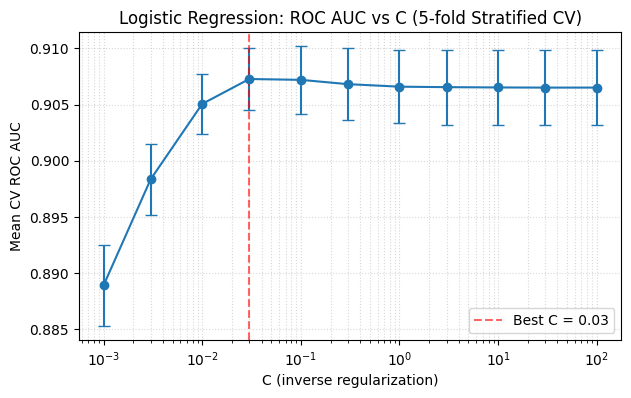

In [62]:
# Plot CV ROC AUC vs C (with error bars)
import matplotlib.pyplot as plt

cvres = pd.DataFrame(grid.cv_results_)
cvres['C'] = cvres['param_clf__C'].astype(float)
cvres = cvres.sort_values('C')

plt.figure(figsize=(7,4))
plt.errorbar(cvres['C'], cvres['mean_test_score'], yerr=cvres['std_test_score'], fmt='-o', capsize=4)
plt.xscale('log')
plt.xlabel('C (inverse regularization)')
plt.ylabel('Mean CV ROC AUC')
plt.title('Logistic Regression: ROC AUC vs C (5-fold Stratified CV)')
best_C = grid.best_params_['clf__C']
plt.axvline(best_C, color='red', linestyle='--', alpha=0.6, label=f'Best C = {best_C}')
plt.legend()
plt.grid(True, which='both', ls=':', alpha=0.5)
plt.show()


The ROC AUC vs C plot shows rapid gains moving away from very small C (strong regularisation, underfitting). The curve peaks around C ≈ 0.03 and then flattens, indicating diminishing returns from further increasing model complexity.

### Evaluate Tuned Model on Test

Use the refit `best_estimator_` to score the held‑out test set and compare results with the baseline baseline (accuracy, confusion matrix, ROC AUC, precision/recall).

In [63]:
# Evaluate tuned model on the held-out test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print('Test Accuracy:', round(accuracy_score(y_test, y_pred), 4))
print('Test Confusion matrix:', confusion_matrix(y_test, y_pred))
print('Test ROC AUC:', round(roc_auc_score(y_test, y_proba), 4))
print('Test Classification report:', classification_report(y_test, y_pred, digits=3))


Test Accuracy: 0.9
Test Confusion matrix: [[7801  184]
 [ 720  338]]
Test ROC AUC: 0.9069
Test Classification report:               precision    recall  f1-score   support

           0      0.916     0.977     0.945      7985
           1      0.648     0.319     0.428      1058

    accuracy                          0.900      9043
   macro avg      0.782     0.648     0.687      9043
weighted avg      0.884     0.900     0.885      9043



### Summary

Best parameter: C = 0.03. Best CV ROC AUC = 0.9073. On the test set, performance is around Accuracy ≈ 0.90, ROC AUC ≈ 0.9069, Precision (positive) ≈ 0.65, Recall (positive) ≈ 0.32. Compared to the baseline, ROC AUC improves slightly (≈0.905 → ≈0.907); precision stays similar while recall dips a bit—consistent with a slightly stronger regularisation/thresholding trade‑off.

---

## Regularisation Variants

**Objective:**  
Explore sparse (L1) and Elastic Net regularisation for logistic regression using the same preprocessing pipeline (StandardScaler + one‑hot passthrough) and C=0.03 from the tuning step.  
This involves:  
- Training `penalty='l1'`, `solver='saga'`, `C=0.03`  
- Training `penalty='elasticnet'`, `solver='saga'`, `l1_ratio=0.5`, `C=0.03`  
- Evaluating each on the test set with accuracy, confusion matrix, ROC AUC, and precision/recall


### L1‑Regularised Logistic Regression (saga)

Train an L1 model with `C=0.03` to encourage sparsity in coefficients; evaluate on the held‑out test set.

In [64]:
# L1-regularised Logistic Regression with saga
prep_q3 = ColumnTransformer([('num', StandardScaler(), numeric_cols)], remainder='passthrough')
pipe_l1 = Pipeline([('prep', prep_q3), ('clf', LogisticRegression(penalty='l1', solver='saga', C=0.03, max_iter=2000, n_jobs=-1))])

pipe_l1.fit(X_train, y_train)
y_pred_l1 = pipe_l1.predict(X_test)
y_proba_l1 = pipe_l1.predict_proba(X_test)[:, 1]

print('L1 Accuracy:', round(accuracy_score(y_test, y_pred_l1), 4))
print('L1 Confusion matrix:', confusion_matrix(y_test, y_pred_l1))
print('L1 ROC AUC:', round(roc_auc_score(y_test, y_proba_l1), 4))
print('L1 Classification report:', classification_report(y_test, y_pred_l1, digits=3))


KeyboardInterrupt: 

### Elastic Net Logistic Regression (saga, l1_ratio=0.5)

Train an Elastic Net model combining L1 and L2 (`l1_ratio=0.5`) with `C=0.03`; evaluate on the held‑out test set.

In [ ]:
# Elastic Net Logistic Regression with saga (l1_ratio=0.5)
prep_q3_en = ColumnTransformer([('num', StandardScaler(), numeric_cols)], remainder='passthrough')
pipe_en = Pipeline([('prep', prep_q3_en), ('clf', LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=0.03, max_iter=2000, n_jobs=-1))])

pipe_en.fit(X_train, y_train)
y_pred_en = pipe_en.predict(X_test)
y_proba_en = pipe_en.predict_proba(X_test)[:, 1]

print('ElasticNet Accuracy:', round(accuracy_score(y_test, y_pred_en), 4))
print('ElasticNet Confusion matrix:', confusion_matrix(y_test, y_pred_en))
print('ElasticNet ROC AUC:', round(roc_auc_score(y_test, y_proba_en), 4))
print('ElasticNet Classification report:', classification_report(y_test, y_pred_en, digits=3))


ElasticNet Accuracy: 0.8998
ElasticNet Confusion matrix: [[7799  186]
 [ 720  338]]
ElasticNet ROC AUC: 0.9071
ElasticNet Classification report:               precision    recall  f1-score   support

           0      0.915     0.977     0.945      7985
           1      0.645     0.319     0.427      1058

    accuracy                          0.900      9043
   macro avg      0.780     0.648     0.686      9043
weighted avg      0.884     0.900     0.885      9043



### Summary

Two alternative regularised logistic regression models were tested:  
- **L1 (Lasso) Logistic Regression**  
- **Elastic Net Logistic Regression**

Both models achieved performance very similar to the tuned L2 model from the tuning step: accuracy ~0.90 and ROC AUC ~0.907. Precision for the positive class was around 0.64–0.65, while recall remained low at ~0.32. 

This indicates that changing the regularisation type did not significantly affect performance on this dataset. However, L1 and Elastic Net regularisation are useful for feature selection and reducing model complexity. In this case, the models were stable but did not substantially improve recall for the minority class.

---

## Model Comparison

**Objective:**  
Compare the baseline L2 logistic regression from  with the L1 and Elastic Net variants from . We report accuracy, ROC AUC, precision, and recall on the held-out test set.


### Compare L2 (Baseline), L1, and Elastic Net

Evaluate all three models using consistent preprocessing and metrics, then summarise results side-by-side.

In [ ]:
# Build/evaluate three models: L2 baseline (), L1, Elastic Net ()
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix

def eval_model(name, est, X_te, y_te):
    y_pred = est.predict(X_te)
    y_proba = est.predict_proba(X_te)[:, 1]
    return {
        'Model': name,
        'Accuracy': round(accuracy_score(y_te, y_pred), 4),
        'ROC_AUC': round(roc_auc_score(y_te, y_proba), 4),
        'Precision_pos': round(precision_score(y_te, y_pred, pos_label=1), 4),
        'Recall_pos': round(recall_score(y_te, y_pred, pos_label=1), 4),
        'ConfusionMatrix': confusion_matrix(y_te, y_pred).tolist(),
    }

# L2 baseline (recreate  pipeline to ensure availability)
prep_l2 = ColumnTransformer([('num', StandardScaler(), numeric_cols)], remainder='passthrough')
pipe_l2 = Pipeline([('prep', prep_l2), ('clf', LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000))])
pipe_l2.fit(X_train, y_train)

# L1 (reuse if available, else create/fit)
try:
    _ = pipe_l1
except NameError:
    prep_q3 = ColumnTransformer([('num', StandardScaler(), numeric_cols)], remainder='passthrough')
    pipe_l1 = Pipeline([('prep', prep_q3), ('clf', LogisticRegression(penalty='l1', solver='saga', C=0.03, max_iter=2000, n_jobs=-1))])
    pipe_l1.fit(X_train, y_train)

# Elastic Net (reuse if available, else create/fit)
try:
    _ = pipe_en
except NameError:
    prep_q3_en = ColumnTransformer([('num', StandardScaler(), numeric_cols)], remainder='passthrough')
    pipe_en = Pipeline([('prep', prep_q3_en), ('clf', LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=0.03, max_iter=2000, n_jobs=-1))])
    pipe_en.fit(X_train, y_train)

# Collect results
import pandas as pd
rows = []
rows.append(eval_model('L2 (Baseline)', pipe_l2, X_test, y_test))
rows.append(eval_model('L1 (saga, C=0.03)', pipe_l1, X_test, y_test))
rows.append(eval_model('Elastic Net (saga, C=0.03, l1_ratio=0.5)', pipe_en, X_test, y_test))
summary_df = pd.DataFrame(rows)[['Model','Accuracy','ROC_AUC','Precision_pos','Recall_pos']]
summary_df


,Model,Accuracy,ROC_AUC,Precision_pos,Recall_pos
0,L2 (Baseline),0.9016,0.9054,0.6474,0.3488
1,"L1 (saga, C=0.03)",0.8991,0.9069,0.6383,0.3185
2,"Elastic Net (saga, C=0.03, l1_ratio=0.5)",0.8998,0.9071,0.6450,0.3195


### Summary

Across the three models, performance is very similar on the held‑out test set. Key observations:

- Best ROC AUC: Elastic Net (0.9071), closely followed by L1 (0.9069) and L2 baseline (0.9054).
- Highest accuracy and recall: L2 baseline (Accuracy 0.9016, Recall 0.3488).
- Precision is comparable across models (~0.64–0.65), with L2 baseline slightly ahead (0.6474).

Interpretation: Changing the regularisation type (L2 → L1/Elastic Net) does not materially change performance on this dataset. Elastic Net offers a marginal gain in ranking quality (ROC AUC) but does not improve positive‑class recall at the default threshold. If improving recall is a goal, consider threshold tuning (e.g., using the precision–recall curve), class_weight='balanced', or cost‑sensitive evaluation.


---

## KNN with Hyperparameter Tuning

**Objective:**  
Continue from  with the same evaluation setting by training a K‑Nearest Neighbors (KNN) classifier and tuning `n_neighbors (K)` on the training set using stratified 5‑fold CV with ROC AUC scoring.


### Build KNN Pipeline

Use the same preprocessing (StandardScaler on numeric columns via ColumnTransformer; one‑hot columns passthrough) and add a `KNeighborsClassifier` as the estimator.

In [ ]:
# KNN pipeline using the existing numeric scaler + one-hot passthrough
from sklearn.neighbors import KNeighborsClassifier
prep_knn = ColumnTransformer([('num', StandardScaler(), numeric_cols)], remainder='passthrough')
pipe_knn = Pipeline([('prep', prep_knn), ('clf', KNeighborsClassifier())])


### Define K Grid and CV Strategy

Tune `n_neighbors` over a range of odd K values to avoid ties. Use `StratifiedKFold(n_splits=5, shuffle=True, random_state=42)` and `scoring="roc_auc"` (suitable for imbalanced data).

In [ ]:
# Define grid and stratified CV
from sklearn.model_selection import StratifiedKFold, GridSearchCV

k_values = [3, 5, 7, 9, 11, 15, 21, 31, 41, 51]
param_grid_knn = {'clf__n_neighbors': k_values}
skf_knn = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


### Run GridSearchCV (KNN)

Perform stratified 5‑fold CV on the training set using ROC AUC; report the best K and mean CV ROC AUC.

In [ ]:
# Grid search for KNN
grid_knn = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid_knn,
    scoring='roc_auc',
    cv=skf_knn,
    n_jobs=-1,
    refit=True,
    verbose=1,
    return_train_score=True
)
grid_knn.fit(X_train, y_train)

print('Best params (KNN):', grid_knn.best_params_)
print('Best CV ROC AUC (KNN):', round(grid_knn.best_score_, 4))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params (KNN): {'clf__n_neighbors': 51}
Best CV ROC AUC (KNN): 0.9078


### Plot ROC AUC vs K

Visualise how validation ROC AUC varies with the number of neighbours K.

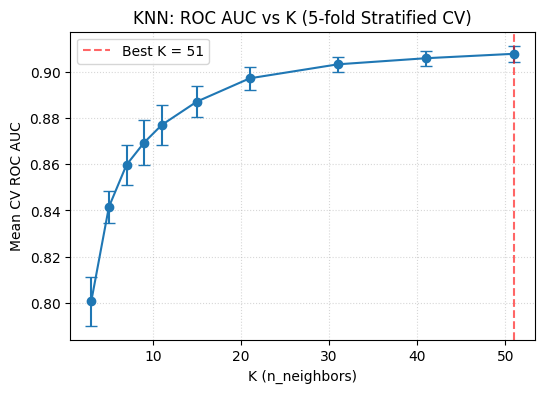

In [ ]:
# Plot CV ROC AUC vs K
import matplotlib.pyplot as plt
cv_knn = pd.DataFrame(grid_knn.cv_results_)
cv_knn['K'] = cv_knn['param_clf__n_neighbors'].astype(int)
cv_knn = cv_knn.sort_values('K')
plt.figure(figsize=(6,4))
plt.errorbar(cv_knn['K'], cv_knn['mean_test_score'], yerr=cv_knn['std_test_score'], fmt='-o', capsize=4)
plt.xlabel('K (n_neighbors)')
plt.ylabel('Mean CV ROC AUC')
plt.title('KNN: ROC AUC vs K (5-fold Stratified CV)')
best_k = grid_knn.best_params_['clf__n_neighbors']
plt.axvline(best_k, color='red', linestyle='--', alpha=0.6, label=f'Best K = {best_k}')
plt.legend()
plt.grid(True, ls=':', alpha=0.5)
plt.show()


### Evaluate Best KNN on Test

Use the refit best KNN model to evaluate accuracy, confusion matrix, ROC AUC, and precision/recall on the held‑out test set.

In [ ]:
# Evaluate tuned KNN on the held-out test set
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
y_pred_knn = grid_knn.predict(X_test)
y_proba_knn = grid_knn.predict_proba(X_test)[:, 1]

print('KNN Test Accuracy:', round(accuracy_score(y_test, y_pred_knn), 4))
print('KNN Test Confusion matrix:', confusion_matrix(y_test, y_pred_knn))
print('KNN Test ROC AUC:', round(roc_auc_score(y_test, y_proba_knn), 4))
print('KNN Test Classification report:', classification_report(y_test, y_pred_knn, digits=3))


KNN Test Accuracy: 0.8956
KNN Test Confusion matrix: [[7872  113]
 [ 831  227]]
KNN Test ROC AUC: 0.904
KNN Test Classification report:               precision    recall  f1-score   support

           0      0.905     0.986     0.943      7985
           1      0.668     0.215     0.325      1058

    accuracy                          0.896      9043
   macro avg      0.786     0.600     0.634      9043
weighted avg      0.877     0.896     0.871      9043



### Summary

The optimal K for KNN was **51**, yielding a mean CV ROC AUC of 0.9078 and test ROC AUC of 0.904. On the test set, accuracy was 0.896 with precision of 0.67 and recall of 0.22 for the positive class.

Compared to logistic regression models (baseline, tuned, L1, and Elastic Net), KNN showed similar ROC AUC but lower recall. While precision for the minority class was slightly higher, KNN missed a larger proportion of positive cases.

Logistic regression models are more efficient, requiring only ~42 trainable parameters, whereas KNN stores all training samples and incurs high prediction-time costs. Logistic regression also benefits from regularisation, which improves generalisation and stability.

KNN underperforms mainly due to the **curse of dimensionality** in the 42-feature space and the imbalanced nature of the dataset. Logistic regression provided better balance between precision and recall, making it more suitable for this problem.

---

## Visualisation of Results

We visualise the selected model’s performance to support the discussion and conclusions:
- **Confusion matrix**: shows error types and class balance at a chosen threshold.
- **ROC curve**: ranking quality across thresholds (AUC as a summary).
- **Precision–Recall**: positive‑class performance under imbalance (AP as a summary).

Review these plots before the final conclusions to ground the takeaways in the observed trade‑offs.

In [ ]:
# Visualisation helpers (confusion matrix, ROC, PR curves)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (roc_curve, auc, precision_recall_curve,
                             average_precision_score, ConfusionMatrixDisplay)

def pick_estimator():
    # Prefer the tuned model if available, else fall back to a baseline pipeline
    g = globals()
    for name in ['grid', 'grid_search', 'best_model']:
        if name in g and hasattr(g[name], 'best_estimator_'):
            return g[name].best_estimator_
    for name in ['pipe', 'pipe_l2', 'clf', 'model']:
        if name in g:
            return g[name]
    raise NameError('No fitted estimator found. Fit a model first.')

def ensure_preds(est, X_te, y_te):
    y_pred = est.predict(X_te)
    if hasattr(est, 'predict_proba'):
        y_proba = est.predict_proba(X_te)[:, 1]
    else:
        # For models without predict_proba (e.g., SVM without probability), use decision_function
        y_proba = getattr(est, 'decision_function')(X_te)
        # Min‑max scale decision scores to [0,1] for curves
        y_min, y_max = y_proba.min(), y_proba.max()
        if y_max > y_min:
            y_proba = (y_proba - y_min) / (y_max - y_min)
    return y_pred, y_proba

def plot_confusion(y_true, y_pred, title='Confusion Matrix'):
    fig, ax = plt.subplots(figsize=(5,4))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues', ax=ax)
    ax.set_title(title)
    plt.tight_layout()

def plot_roc(y_true, y_score, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    fig, ax = plt.subplots(figsize=(5,4))
    ax.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    ax.plot([0,1], [0,1], 'k--', alpha=0.6)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc='lower right')
    plt.tight_layout()

def plot_pr(y_true, y_score, title='Precision–Recall Curve'):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    fig, ax = plt.subplots(figsize=(5,4))
    ax.plot(recall, precision, label=f'AP = {ap:.3f}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.legend(loc='lower left')
    plt.tight_layout()


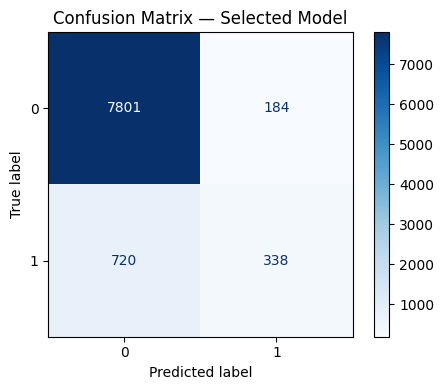

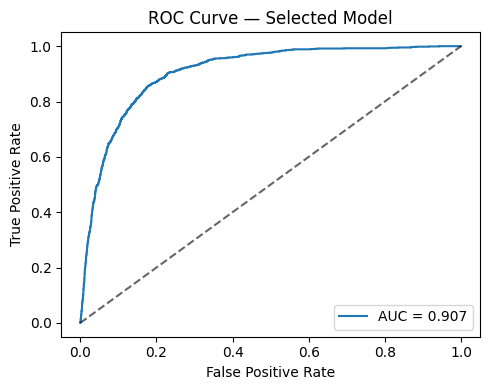

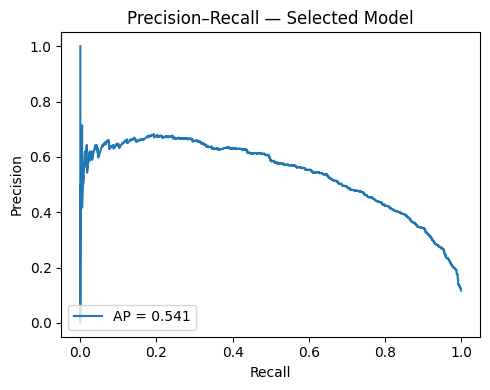

In [ ]:
# Generate professional plots using the chosen estimator
est = pick_estimator()
y_pred, y_score = ensure_preds(est, X_test, y_test)

plot_confusion(y_test, y_pred, title='Confusion Matrix — Selected Model')
plot_roc(y_test, y_score, title='ROC Curve — Selected Model')
plot_pr(y_test, y_score, title='Precision–Recall — Selected Model')


## Conclusion & Next Steps

The models achieve strong overall ranking performance (ROC AUC ≈ 0.90), with high precision but lower recall for the positive class, reflecting the dataset's imbalance. For a marketing use case, this suggests careful threshold selection and cost‑sensitive evaluation are needed to balance conversion lift against contact costs.

Key insights:

- **Logistic regression** provided stable performance (~0.90 accuracy, ~0.907 ROC AUC). Regularisation (L1, L2, Elastic Net) balanced complexity and generalisation.
- **KNN** achieved similar ROC AUC but required many neighbours (K=51) and had lower recall — inefficient in high‑dimensional, imbalanced data.
- Looking beyond accuracy (ROC AUC, precision, recall) was essential to assess models fairly under class imbalance.

Overall, this project demonstrated a complete supervised‑learning workflow: preprocessing, baseline modelling, hyperparameter tuning, regularisation, and algorithm comparison, highlighting trade‑offs between simplicity, interpretability, and predictive performance.

Next steps:
- Threshold tuning with cost assumptions (e.g., maximise expected net benefit).
- Probability calibration and lift/gain analysis to support campaign planning.
- Compare against tree‑based models (Random Forest, Gradient Boosting) and interpret with SHAP.
- Address imbalance via class weights or resampling (SMOTE) and re‑evaluate PR metrics.
- Cross‑validation on temporal splits if campaign timing matters.
